In [1]:
from bspline   import elements_spans  # computes the span for each element
from bspline   import make_knots,basis_funs,find_span     # create a knot sequence from a grid
from bspline   import quadrature_grid ,breakpoints# create a quadrature rule over the whole 1d grid
from bspline   import basis_ders_on_quad_grid,basis_funs_all_ders # evaluates all bsplines and their derivatives on the quad grid
from Gauss_Legendre import Gauss_Legendre, quadrature_grid
from stdio     import Mass_Matrix, Stiffness_Matrix, assemble_rhs_with_Non_homogenuous_DBC
from stdio     import B_Spline_Least_Square, assemble_stiffness_2D, L2_projection
from equipment import L2_norm_2D, H1_norm_2D, plot_field_2D
from scipy.sparse.linalg import cg
from scipy.linalg import norm, inv, solve, det,inv
from numpy import zeros, ones, linspace,double,float64, cos,array, dot, zeros_like, asarray,floor,arange,append,random,sqrt, int32, meshgrid, kron,sin
import  matplotlib.pyplot as plt
from scipy.sparse        import csr_matrix
from scipy.sparse        import csc_matrix, linalg as sla
from scipy.sparse.linalg import gmres
from numpy               import zeros, linalg, asarray
from numpy               import cos, pi

#from matplotlib.pyplot import plot, show
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from matplotlib.ticker import LinearLocator, FormatStrFormatter


In [26]:
ne1, ne2                = (64,64)
grid1, grid2            = linspace(0,1,ne1+1), linspace(0,1, ne2+1)            
p1,p2                   = (3,3)
knots1, knots2          = make_knots(grid1, p1, False), make_knots(grid2, p2, False)
spans1, spans2          = elements_spans(knots1, p1), elements_spans(knots2, p2)
nelements1, nelements2  = len(grid1)-1,len(grid2)-1
nbasis1, nbasis2        = len(knots1)-p1-1, len(knots2)-p2-1
nders                   = 1
U1 , W1                 = Gauss_Legendre(p1)
U2 , W2                 = Gauss_Legendre(p2)
points1, weights1       = quadrature_grid(grid1,U1,W1)
points2, weights2       = quadrature_grid(grid2,U2,W2)
basis1, basis2          = basis_ders_on_quad_grid(knots1, p1, points1, nders, normalize=False),basis_ders_on_quad_grid(knots2, p2, points2, nders, normalize=False)

In [27]:
from pyccel.decorators import template
@template('float')
def tensor_to_matrix(Mat: 'float[:,:,:,:]', nh: int, nm: int) ->'float[:,:]':
    sti = zeros((nh * nm, nh * nm), dtype=float64)
    for i in range(nh):
        for j in range(nm):
            for k in range(nh):
                for l in range(nm):
                    i_1 = k + i * nm
                    i_2 = l + j * nh
                    sti[i_1, i_2] = Mat[i, j, k, l]                    
    return sti   

In [28]:
'''
in 2D isogeometric analysis, the Kronecker assembly process involves
constructing the global stiffness or mass matrix by combining element-level
matrices using Kronecker products.This method leverages the tensor-product structure 
of the basis functions in IGA to efficiently assemble the global matrices
'''

stiffness1      = zeros((nbasis1,nbasis2))
stiffness2      = zeros((nbasis1,nbasis2))
mass1           = zeros((nbasis1,nbasis2))
mass2           = zeros((nbasis1,nbasis2))
stiffness1      = Stiffness_Matrix(nelements1, p1, spans1, basis1, weights1, points1, stiffness1)
stiffness2      = Stiffness_Matrix(nelements2, p2, spans2, basis2, weights2, points2, stiffness2)
mass1           = Mass_Matrix(nelements1, p1, spans1, basis1, weights1, points1, mass1)
mass2           = Mass_Matrix(nelements2, p2, spans2, basis2, weights2, points2, mass2)
C1              = kron(stiffness1[1:-1,1:-1],mass2[1:-1,1:-1])

C2              = kron(mass1[1:-1,1:-1], stiffness2[1:-1,1:-1])
# C1              = kron(stiffness1,mass2)
# C2              = kron(mass1,stiffness2)
stiffness_total = C1+C2

In [29]:

from pyccel.decorators import template
@template('float')
def tensor_to_matrix(Mat: 'float[:,:,:,:]', nh: int, nm: int) ->'float[:,:]':
    sti = zeros((nh * nm, nh * nm), dtype=float64)
    for i in range(nh):
        for j in range(nm):
            for k in range(nh):
                for l in range(nm):
                    i_1 = k + i * nm
                    i_2 = l + j * nh
            
                    sti[i_1, i_2] = Mat[i, j, k, l]                    
    return sti  
stiffness = zeros((nbasis1, nbasis2, nbasis1, nbasis2))
stiffness = assemble_stiffness_2D((nbasis1, nbasis2),(nelements1, nelements2 ), (p1, p2), (spans1, spans2), (basis1, basis2), (weights1, weights2), (points1, points2), stiffness)
stiffness = tensor_to_matrix(stiffness[1:-1,1:-1,1:-1,1:-1], nbasis1-2, nbasis2-2)


## Boundary  Dirichlet conditions on unit square.

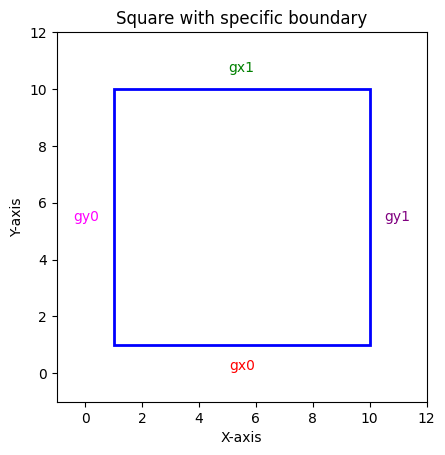

In [30]:
# Define the boundaries of the square
left     = 1
right    = 10
top      = 10
bottom   = 1
square   = plt.Rectangle((left, bottom), right - left, top - bottom, edgecolor='blue', facecolor='none',  linewidth=2)
fig, ax  = plt.subplots()
ax.add_patch(square)
ax.set_xlim(left -2, right + 2)
ax.set_ylim(bottom -2, top + 2)
ax.set_aspect('equal')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.text(left + (right - left) / 2, bottom - 0.5, 'gx0', ha='center', va='top', fontsize=10, color='red')
ax.text(left + (right - left) / 2, top + 0.5, 'gx1', ha='center', va='bottom', fontsize=10, color='green')
ax.text(left - 0.5, bottom + (top - bottom) / 2, 'gy0', ha='right', va='center', fontsize=10, color='magenta')
ax.text(right + 0.5, bottom + (top - bottom) / 2, 'gy1', ha='left', va='center', fontsize=10, color='purple')
plt.title("Square with specific boundary")
plt.show()

In [31]:
#Test 1

gx0 = lambda x    :  0.
gx1 = lambda x    :  2.* cos(pi*x)
gy0 = lambda y    :  2.* y 
gy1 = lambda y    : -2.* y
Uex = lambda x, y : 2.*x*cos(pi*y) 
dUx = lambda x, y : 2.*cos(pi*y)  
dUy = lambda x, y : -2*pi*x*sin(pi*y)
f   = lambda x, y : 2.*x*pi**2*cos(pi*y)


# Test 2
# kappa = 1
# gx0   = lambda x   :  1 - sin(2*kappa*pi*x) 
# gx1   = lambda x   : -1- sin(2*kappa*pi*x)
# gy0   = lambda y   : cos(pi*kappa*y)
# gy1   = lambda y   : cos(pi*kappa*y)
# Uex   = lambda x,y : cos(pi*kappa*x)- sin(2*kappa*pi*y)
# dUx   = lambda x,y : -pi*kappa*sin(pi*kappa*x)
# dUy   = lambda x,y : - 2*kappa*pi*cos(2*kappa*pi*y)
# f     = lambda x,y : (pi*kappa)**2*cos(pi*kappa*x)- (2*kappa*pi)**2*sin(2*kappa*pi*y)

rhs1          = zeros((nbasis1,nbasis2))
###################################################B-spline least square ##############################################
# gx0_h         = B_Spline_Least_Square(nelements1, gx0, p1, spans1, basis1, weights1, points1)
# gx1_h         = B_Spline_Least_Square(nelements1, gx1, p1, spans1, basis1, weights1, points1)
# gy0_h         = B_Spline_Least_Square(nelements2, gy0, p2, spans2, basis2, weights2, points2)
# gy1_h         = B_Spline_Least_Square(nelements2, gy1, p2, spans2, basis2, weights2, points2)
###################################################L2 projection ############################################
gx0_h         = L2_projection(knots1, p1, gx0)
gx1_h         = L2_projection(knots1, p1, gx1)
gy0_h         = L2_projection(knots2, p2, gy0)
gy1_h         = L2_projection(knots2, p2, gy1)

g_bou         = zeros((nbasis1, nbasis2))
g_bou[0,:]    = gx0_h
g_bou[-1,:]   = gx1_h
g_bou[:,0]    = gy0_h
g_bou[:,-1]   = gy1_h
rhs1          = assemble_rhs_with_Non_homogenuous_DBC(f,g_bou, nbasis1, (nelements1, nelements2 ), (p1, p2), (spans1, spans2), (basis1, basis2), (weights1, weights2), (points1, points2), rhs1)
rhs1          = rhs1[1:-1, 1:-1]
rhs1          = rhs1.reshape((nbasis1-2)*(nbasis2-2))

In [32]:
lu            = sla.splu(csc_matrix(stiffness))
Uapp          = lu.solve(rhs1) 
Uh            = zeros((nbasis1,nbasis2))
Uh[1:-1,1:-1] = Uapp.reshape((nbasis1-2),(nbasis2-2))
Uh            = Uh + g_bou

In [33]:
def plot_field_2D(knots, degree, u, nx = 101, ny=101):
    knots1, knots2 = knots
    degree1, degree2 = degree
    xmin, xmax, ymin ,ymax = knots1[degree1], knots1[-degree1], knots2[degree2], knots2[-degree2]
    
    xs = linspace(xmin, xmax, nx)
    ys = linspace(ymin, ymax, ny)
    
    P = zeros((nx,ny,1))
    nu1,nu2 = u.shape
    Q = zeros((nu1,nu2))
    Q[:,:]= u[:,:]
    for i ,xi in enumerate(xs):
        for j,yj in enumerate(xs):
            i_span = find_span(knots1, degree1, xi)
            j_span = find_span(knots2, degree2, yj)
            valuesx = basis_funs(knots1, degree1, xi, i_span)
            valuesy = basis_funs(knots2, degree2, yj, j_span)
            C = zeros(P.shape[-1])
            for i_1 in range(degree1+1):
                for j_1 in range(degree2+1):
                    C[:]+=valuesx[i_1]*valuesy[j_1]*Q[i_span-degree1+i_1, j_span-degree2+j_1]
            P[i,j,:] = C[:]
    X,Y = meshgrid(xs,ys)
    ax = plt.axes(projection = '3d')
    
    # plt.contourf(X,Y, P[:,:,0].T)
    # ax.plot_surface(X,Y, P[:,:,0].T, cmap ='viridis', edgecolor ='orange')

    ax.plot_surface(X, Y, P[:,:,0].T, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    # ax.set_title('Approximate solution')
    ax.set_xlabel('X',  fontweight ='bold')
    ax.set_ylabel('Y',  fontweight ='bold')
    plt.savefig('Poisson3D_Appro.png')
    # Add a color bar which maps values to colors.
    plt.show()

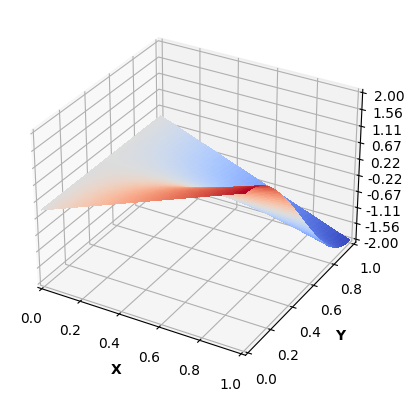

In [34]:
plot_field_2D((knots1,knots2), (p1,p2), Uh, nx=100, ny=100)

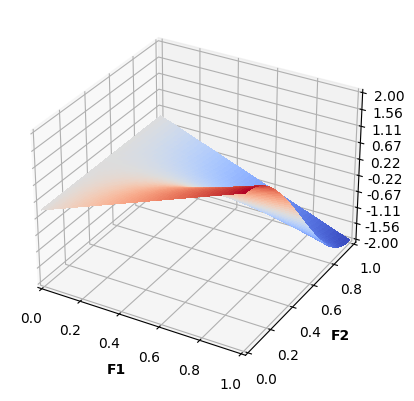

In [35]:
nbpts = 250
xs = ys = linspace(0., 1., nbpts)
X, Y = meshgrid(xs, ys)

# sol = zeros((nbpts,nbpts))
# for i in range(nbpts) :
#     for j in range(nbpts) :
#         sol[i, j] = Uex(X[i,j], Y[i,j])
sol =  Uex(X, Y)
ax = plt.axes(projection = '3d')
    
# ax.plot_surface(X,Y, sol, cmap ='viridis', edgecolor ='orange')
ax.plot_surface(X, Y, sol, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('F1',  fontweight ='bold')
ax.set_ylabel('F2',  fontweight ='bold')
plt.savefig('Poisson3D.png')
# plt.contourf(X,Y, sol)

In [36]:
L2 = L2_norm_2D( (nelements1, nelements2 ), (p1, p2), (spans1, spans2), (basis1, basis2), (weights1, weights2), (points1, points2), Uh, Uex)
L2

4.365336992335023e-09

In [38]:

H1 = H1_norm_2D( (nelements1, nelements2 ), (p1, p2), (spans1, spans2), (basis1, basis2), (weights1, weights2), (points1, points2), Uh, dUx, dUy, Uex)
H1

1.7250814410652454e-06